In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse
import pytictoc

from femns2d import femns2d

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def create_tube(L=10, r=0.5, pfactor=0.1, name="tube.msh"):
    gmsh.initialize()
    gmsh.model.add('tube')
    
    if hasattr(r, '__len__'):
        rup, rdown = r[0], r[1]
    else:
        rup = rdown = r
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, -1, 0, pfactor, 1)
    gmsh.model.geo.addPoint(L/4-rdown, -1, 0, pfactor, 2)
    gmsh.model.geo.addPoint(L/4, -1+rdown, 0, pfactor, 3)
    gmsh.model.geo.addPoint(L/4+rdown, -1, 0, pfactor, 4)
    gmsh.model.geo.addPoint(L, -1, 0, pfactor, 5)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 10)
    gmsh.model.geo.addPoint(L/4-rup, 1, 0, pfactor, 9)
    gmsh.model.geo.addPoint(L/4, 1-rup, 0, pfactor, 8)
    gmsh.model.geo.addPoint(L/4+rup, 1, 0, pfactor, 7)
    gmsh.model.geo.addPoint(L, 1, 0, pfactor, 6)
    gmsh.model.geo.addPoint(L/4, -1, 0, pfactor, 11)
    gmsh.model.geo.addPoint(L/4, 1, 0, pfactor, 12)

    gmsh.model.geo.addLine(1, 2, 1)
    
    gmsh.model.geo.addCircleArc(2, 11, 3, 2)
    gmsh.model.geo.addLine(3, 11, 3)
    gmsh.model.geo.addLine(11, 5, 4)
    gmsh.model.geo.addLine(5, 6, 5)
    gmsh.model.geo.addLine(6, 7, 6)
    gmsh.model.geo.addCircleArc(7, 12, 8, 7)
    gmsh.model.geo.addCircleArc(8, 12, 9, 8)
    gmsh.model.geo.addLine(9, 10, 9)
    gmsh.model.geo.addLine(10, 1, 10)
    
    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1, 2, 3, 4], 1)
    gmsh.model.geo.addPhysicalGroup(1, [5], 2)
    gmsh.model.geo.addPhysicalGroup(1, [6, 7, 8, 9], 3)
    gmsh.model.geo.addPhysicalGroup(1, [10], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('tube.msh')

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Circle)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Circle)
Info    : [ 70%] Meshing curve 8 (Circle)
Info    : [ 80%] Meshing curve 9 (Line)
Info    : [ 90%] Meshing curve 10 (Line)
Info    : Done meshing 1D (Wall 0.00376649s, CPU 0.00551s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.150947s, CPU 0.148254s)
Info    : 2831 nodes 5668 elements
Info    : Writing 'tube.msh'...
Info    : Done writing 'tube.msh'



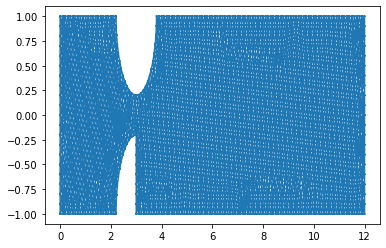

In [5]:
# Read the mesh file
tube_length = 12
choke_radius = 0.8
point_factor = 0.1
create_tube(tube_length, choke_radius, point_factor)
mesh = meshio.read("tube.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [7]:
Re = 30.0
steps = 1000
tol = 1e-3
velocity_cap = None
Re_init = 0.1
Re_schedule = np.linspace(0.1, Re, steps)

In [ ]:
# dirichlet_bcs_u = [[0, 0], [1, 3]]
# dirichlet_bcs_v = [[0, 0], [1, 3]]
# dirichlet_bcs_p = [[5, 0], [4, 2]]
tictoc = pytictoc.TicToc()
tictoc.tic()
for Re in [10.0, 20.0, 30.0, 40.0, 50.0]:
    for step in range(steps):
        Rei = Re
        assembler = femns2d.MiniAssembler(mesh)
        ex = np.array([1.0, 0.0])
        ey = np.array([0.0, 1.0])
        K = assembler.stiffness_matrix()
        Azero = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
        Azerop = scipy.sparse.dok_matrix((assembler.npoints, assembler.npoints))
        Guxp = Rei*assembler.velocity_pressure_convection_matrix(ex)
        Guyp = Rei*assembler.velocity_pressure_convection_matrix(ey)
        Gpux = Guxp.T
        Gpuy = Guyp.T
        if step == 0: #Initial solution, Stokes in practice
            Ginertia = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
        else:
            ue = assembler.get_element_velocities(uxyp)
            Ginertia = assembler.convection_matrix(lambda i :ue[i], velocity_fn_type='element')
            Ginertia = Rei*Ginertia
        KG = K + Ginertia
        Au = scipy.sparse.bmat([[KG, Azero, Guxp]])
        Av = scipy.sparse.bmat([[Azero, KG, Guyp]])
        Ap = scipy.sparse.bmat([[Gpux, Gpuy, Azerop]])
        A = scipy.sparse.bmat([[Au], [Av], [Ap]])
        A = scipy.sparse.dok_matrix(A)
        u_bc_func = lambda x : 1-(x[..., 1]**2)
        dirichlet_bcs_u = [[u_bc_func, u_bc_func, 0, 0], [4, 2, 1, 3]]
        dirichlet_bcs_v = [[0, 0, 0, 0], [4, 1, 3]]
        dirichlet_bcs_p = [[0], [2]]

        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], A, 'p')
        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_u[1], A, 'u')
        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_v[1], A, 'v')
        A_sparse = A.tocsc()

        f = np.hstack([assembler.forcing_vector(0.0),
                       assembler.forcing_vector(0.0),
                       assembler.forcing_vector(0.0)[:assembler.npoints]])

        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, f, 'p')
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_u, f, 'u')
        f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_v, f, 'v')
        uxyp_new = scipy.sparse.linalg.spsolve(A_sparse, f)
        if velocity_cap is not None:
            ux, uy, p = assembler.split_velocities(uxyp_new)
            velocities = np.sqrt(ux**2 + uy**2)
            normalizations = np.clip(velocities/velocity_cap, 1.0, None)
            normalizations = np.hstack([normalizations, normalizations, np.ones(assembler.npoints)])
            uxyp_new /= normalizations
        if step == 0:
            uxyp = uxyp_new.copy()
            uxyp_stokes = uxyp.copy()
        else:
            duxyp = uxyp_new - uxyp
            error = np.max(np.abs(duxyp))
            uxyp = uxyp_new.copy()
            print(step, error)
            if error < tol:
                break
        
    tictoc.toc()
    np.savez(f"results_ns/results_choked_long_{Re}.npz", uxyp=uxyp, uxyp_stokes=uxyp_stokes)


1 8.997304711953063
2 1.40681987759692
3 0.3956074560433951
4 0.08881654840252029
5 0.01690838135001327
6 0.004793696987793528
7 0.0019946919329683066
8 0.000928295401854129
Elapsed time is 429.090082 seconds.
1 7.9332263991334315
2 2.288364769811597
3 0.8095337328754693
4 0.22426479677991884
5 0.11353361891854796
6 0.08426609017666253
7 0.06669869846664889
8 0.05395680531462688


<Figure size 432x288 with 0 Axes>

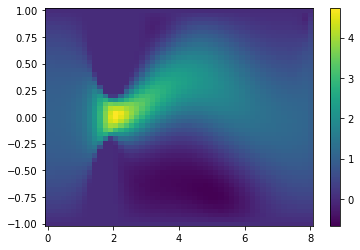

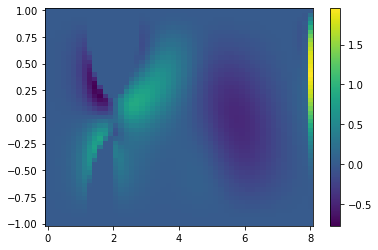

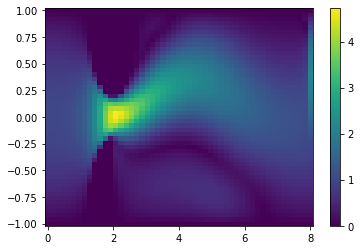

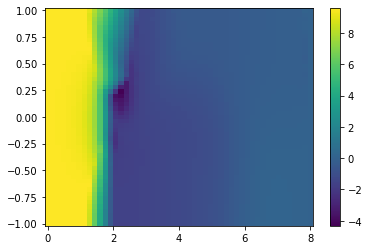

<Figure size 432x288 with 0 Axes>

In [41]:
ux, uy, p = assembler.split_velocities(uxyp)
ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 8, 51), np.linspace(-1, 1, 51))
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
Usize = np.sqrt(UX**2 + UY**2)
P = p_interp(X, Y)
for Z in [UX, UY, Usize, P]:
    plt.figure()
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar()

n = 51
x = np.ones(n)*5.0
y = np.linspace(-1, 1, n)
ux = ux_interp(x, y)
uy = uy_interp(x, y)

plt.figure()

In [42]:
np.max(ux)

2.0056877546492613

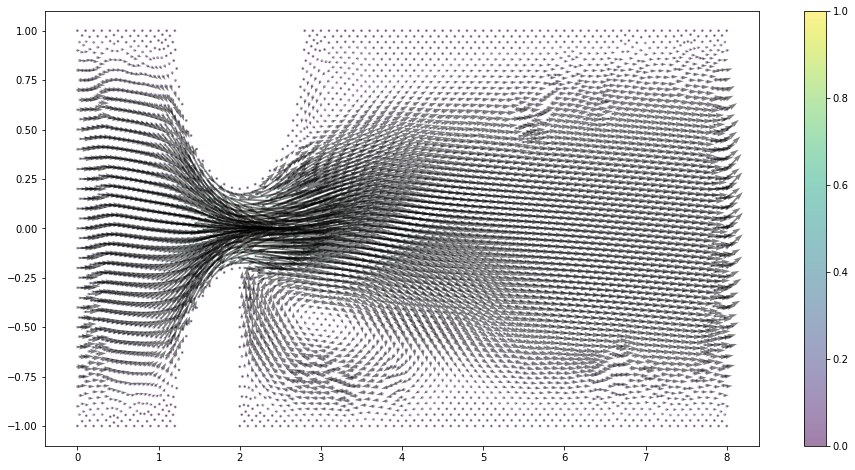

In [35]:
x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
ux, uy, p = assembler.split_velocities(uxyp)

plt.figure(figsize=(2*tube_length, tube_length))
plt.scatter(assembler.pointse[:, 0], assembler.pointse[:, 1], s=4,
            c=np.sqrt(ux**2 + uy**2), cmap='viridis', alpha=0.25)
plt.quiver(x, y, ux, uy, angles='xy', scale_units='xy', scale=5, alpha=0.5)
plt.colorbar()

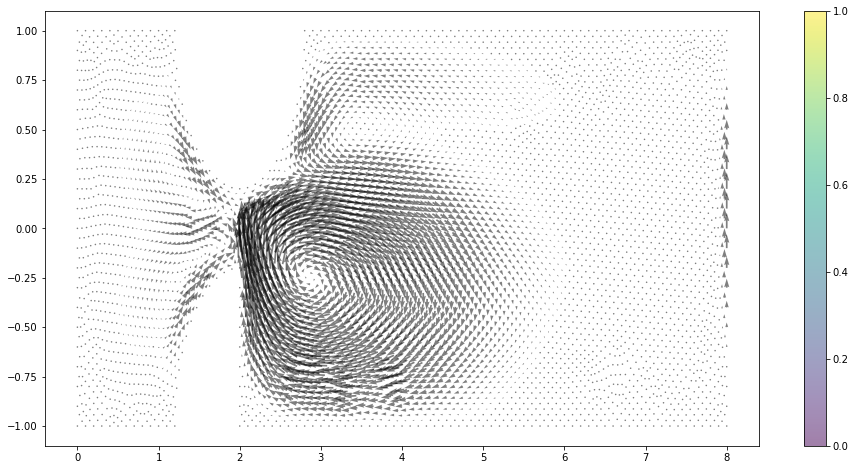

In [36]:
x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
ux_s, uy_s, p_s = assembler.split_velocities(uxyp_stokes)
dux, duy, dp = ux - ux_s, uy-uy_s, p - p_s
plt.figure(figsize=(2*tube_length, tube_length))
# plt.scatter(assembler.pointse[:, 0], assembler.pointse[:, 1], s=4,
#             c=ux**2 + uy**2, cmap='viridis', alpha=0.25)
plt.quiver(x, y, dux, duy, angles='xy', scale_units='xy', scale=5, alpha=0.5)
plt.colorbar()

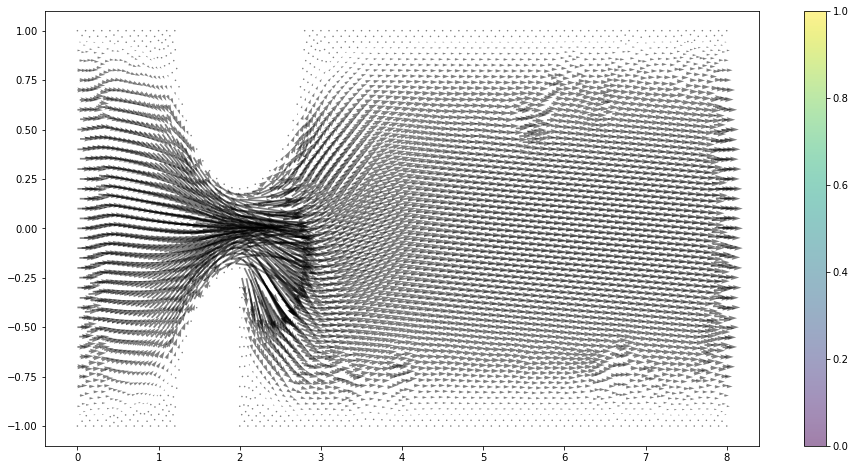

In [37]:
x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
ux_s, uy_s, p_s = assembler.split_velocities(uxyp_stokes)
dux, duy, dp = ux - ux_s, uy-uy_s, p - p_s
plt.figure(figsize=(2*tube_length, tube_length))
# plt.scatter(assembler.pointse[:, 0], assembler.pointse[:, 1], s=4,
#             c=ux**2 + uy**2, cmap='viridis', alpha=0.25)
plt.quiver(x, y, ux_s, uy_s, angles='xy', scale_units='xy', scale=5, alpha=0.5)
plt.colorbar()

In [32]:
np.savez("results_choked.npz", uxyp=uxyp, uxyp_stokes=uxyp_stokes)

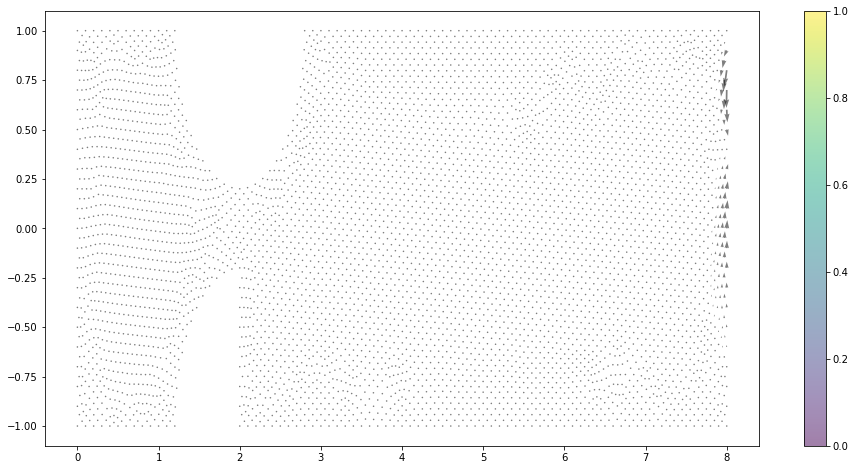

In [49]:
x, y = assembler.pointse[:, 0], assembler.pointse[:, 1]
dux, duy, dp = assembler.split_velocities(duxyp)
plt.figure(figsize=(2*tube_length, tube_length))
# plt.scatter(assembler.pointse[:, 0], assembler.pointse[:, 1], s=4,
#             c=ux**2 + uy**2, cmap='viridis', alpha=0.25)
plt.quiver(x, y, dux, duy, angles='xy', scale_units='xy', scale=5, alpha=0.5)
plt.colorbar()